In [274]:
# Load libraries
import pandas as pd
import numpy as np

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.cross_decomposition import PLSRegression

from tabulate import tabulate
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Reshape, GaussianNoise
from keras.callbacks import ReduceLROnPlateau

**Tutorials and references**

Tutuorial on using LazyRegressor
https://towardsdatascience.com/train-all-classification-or-regression-models-in-one-line-of-python-code-4ccdcaf01f0c

Scatter correction with NIR outliners 
https://github.com/EBjerrum/Deep-Chemometrics

Neural network for NIR
https://github.com/j-planet/machine-learning-big-loop

# This is a three part analysis </br>
1. Explore several models with LazyRegressor </br>
2. Evaluate two models and optimize parameters with a grid approach </br>
3. Create a neural network model

In [27]:
# Load data
df=pd.read_csv('C:/Users/sarahann.USERS/Desktop/code/NIR_model/PC4.csv')
X = df.iloc[:, 1:]
# y = target values, last column of the data frame
y = df.iloc[:, 0]

In [28]:
# Functions for scatter correction
def msc(input_data, reference=None):
    """
        :msc: Scatter Correction technique performed with mean of the sample data as the reference.
        :param input_data: Array of spectral data
        :type input_data: DataFrame
        :returns: data_msc (ndarray): Scatter corrected spectra data
    """
    eps = np.finfo(np.float32).eps
    input_data = np.array(input_data, dtype=np.float64)
    ref = []
    sampleCount = int(len(input_data))

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    
    # Get the reference spectrum. If not given, estimate it from the mean
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        for j in range(0, sampleCount, 10):
            ref.append(np.mean(input_data[j:j+10], axis=0))
            # Run regression
            fit = np.polyfit(ref[i], input_data[i,:], 1, full=True)
            # Apply correction
            data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]
    
    return (data_msc)

def snv(input_data):
    """
        :snv: A correction technique which is done on each
        individual spectrum, a reference spectrum is not
        required
        :param input_data: Array of spectral data
        :type input_data: DataFrame
        
        :returns: data_snv (ndarray): Scatter corrected spectra
    """
    input_data = np.asarray(input_data)
    
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(data_snv.shape[0]):
    # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    
    return (data_snv)

In [109]:
# Scatter Correction and Scale Data (z-score method)
msc_X=msc(X, reference=None)
X_snv=snv(msc_X)

# Split data, with 20% in test sample
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_snv)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.25)

# Part 1
**Crude run of several models without parameter fitting**

In [167]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:10<00:00,  3.97it/s]


In [168]:
predictions['RMSE']=np.sqrt(predictions['RMSE']) # I think this library is kicking back MSE as opposed to RMSE so I adjusted
print(tabulate(round(predictions,2), headers=['Adjusted R-Square', 'R-Square', 'RMSE', 'Time']))

                                 Adjusted R-Square       R-Square      RMSE    Time
-----------------------------  -------------------  -------------  --------  ------
Lars                                   2.14815e+19   -2.81724e+19  91630.1     0.05
KernelRidge                           37.36         -46.68             3.3     0.02
GaussianProcessRegressor              23.19         -28.1              2.92    0.03
MLPRegressor                           3.37          -2.1              1.67    0.43
RANSACRegressor                        2             -0.32             1.35    1.53
LassoLars                              1.78          -0.03             1.27    0.01
Lasso                                  1.78          -0.03             1.27    0.02
DummyRegressor                         1.78          -0.03             1.27    0.02
ElasticNet                             1.76           0                1.26    0.02
LarsCV                                 1.75           0.02             1.25 

# Part 2
**Orthogonal andMatching Pursuit CV  and PLS Models**
The Orthogonal model performed best, and generally models with sparse decisions realms (distributions) performed better. Also a benchmark PLS model is created. </br>
The next cells develop the models of OMP CV and PLS respectively by. </br>
1. Identifying optimal parameters with a grid search
2. Testing model with optimized parameters

In [235]:
#Orthogonal Model
# prepare a range of parameter values to test
cvs = np.arange(2,50)
iterations = np.arange(20,100)


model = OrthogonalMatchingPursuitCV()
grid = GridSearchCV(estimator=model, param_grid=dict(cv=cvs, max_iter= iterations))
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.cv)
print(grid.best_estimator_.max_iter)

GridSearchCV(estimator=OrthogonalMatchingPursuitCV(),
             param_grid={'cv': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'max_iter': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})
0.9304665358878301
17
20


In [283]:
model = OrthogonalMatchingPursuitCV(max_iter=20, cv=17).fit(X_train, y_train)
predictions = model.predict(X_test)
score = {'RSME':[], 'Cross Validation Score':[],'R-Square':[]}

# evaluate the model and print the accuracies list
rsme = np.sqrt(mean_squared_error(y_test, predictions)) 
cross_val = np.sqrt(-1*cross_val_score(model,X_scale, y,cv=10, scoring="neg_mean_squared_error").mean())
R_square = model.score(X_test, y_test) 

score['RSME'].append(rsme)
score['Cross Validation Score'].append(cross_val)
score['R-Square'].append(R_square)

print('Performance of OMP CV model')
print(tabulate(score, headers=['RSME', 'Cross Validation Score', 'R-Square']))

Performance of OMP CV model
    RSME    Cross Validation Score    R-Square
--------  ------------------------  ----------
0.648546                  0.541319    0.831906


In [280]:
# PLS model
# prepare a range of parameter values to test
n = np.arange(2,50)
iterations = np.arange(20,100)

model = PLSRegression()
grid = GridSearchCV(estimator=model, param_grid=dict(n_components=n, max_iter= iterations))
grid.fit(X_train, y_train)

print(grid)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_components)
print(grid.best_estimator_.max_iter)

GridSearchCV(estimator=PLSRegression(),
             param_grid={'max_iter': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})
0.9283847703262831
17
20


In [284]:
model = PLSRegression(n_components=17, max_iter= 20).fit(X_train, y_train)
predictions = model.predict(X_test)
score = {'RSME':[], 'Cross Validation Score':[],'R-Square':[]}

# evaluate the model and print the accuracies list
rsme = np.sqrt(mean_squared_error(y_test, predictions)) 
cross_val = np.sqrt(-1*cross_val_score(model,X_scale, y,cv=10, scoring="neg_mean_squared_error").mean())
R_square = model.score(X_test, y_test) 

score['RSME'].append(rsme)
score['Cross Validation Score'].append(cross_val)
score['R-Square'].append(R_square)

print('Performance of PLS model')
print(tabulate(score, headers=['RSME', 'Cross Validation Score', 'R-Square']))

Performance of PLS model
    RSME    Cross Validation Score    R-Square
--------  ------------------------  ----------
0.587998                  0.596529    0.861827


# Part 3
**Develop a RNN mode**

In [324]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = .5 # .5
C1_K  = 20 #8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32
activation='relu'

input_dim = X_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1) ))
    model.add(Conv1D(C1_K, (C1_S), padding='valid' ,activation=activation)) 
    model.add(Conv1D(C2_K, (C2_S), padding='valid' ,activation=activation)) 
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))

    return model

In [325]:
model = make_model()
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_14 (GaussianN (None, 141)               0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 141, 1)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 110, 20)           660       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 79, 16)            10256     
_________________________________________________________________
flatten_11 (Flatten)         (None, 1264)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1264)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)             

In [326]:
rdlr = ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
h = model.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), callbacks=[rdlr])

Epoch 1/150
10/10 [==============================] - 1s 55ms/step - loss: 113.1581 - val_loss: 114.6557
Epoch 2/150
10/10 [==============================] - 0s 12ms/step - loss: 110.6723 - val_loss: 111.6437
Epoch 3/150
10/10 [==============================] - 0s 11ms/step - loss: 107.2893 - val_loss: 108.2440
Epoch 4/150
10/10 [==============================] - 0s 10ms/step - loss: 104.3657 - val_loss: 104.0970
Epoch 5/150
10/10 [==============================] - 0s 10ms/step - loss: 98.2302 - val_loss: 98.9502
Epoch 6/150
10/10 [==============================] - 0s 10ms/step - loss: 95.0913 - val_loss: 92.4292
Epoch 7/150
10/10 [==============================] - 0s 10ms/step - loss: 92.5200 - val_loss: 84.7226
Epoch 8/150
10/10 [==============================] - 0s 10ms/step - loss: 80.8385 - val_loss: 75.2654
Epoch 9/150
10/10 [==============================] - 0s 10ms/step - loss: 71.7783 - val_loss: 64.3468
Epoch 10/150
10/10 [==============================] - 0s 9ms/step - loss: 

No handles with labels found to put in legend.


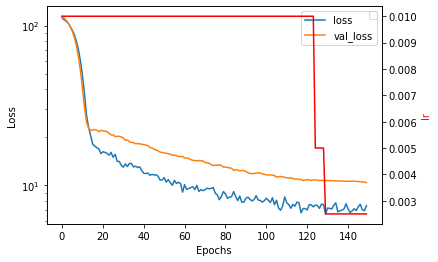

In [327]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('lr',color='r')

plt.legend()

In [328]:
rsme = np.sqrt(mean_squared_error(y_test, model.predict(X_test))) 
rsme

3.2302646553781207

Text(0.5, 1.0, '$Y_i$ vs $\\hat{Y}_i$')

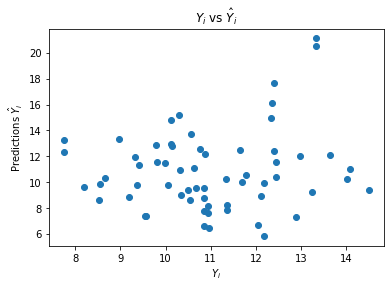

In [329]:
# Plot the predicted value vs true value for RNN
plt.scatter(y_test, model.predict(X_test))
plt.xlabel("$Y_i$")
plt.ylabel("Predictions $\hat{Y}_i$")
plt.title("$Y_i$ vs $\hat{Y}_i$")